Model-training for Two Sigma & RentHop's Kaggle contest on rental listing inquiries.  
https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries

We are given some statistics and information about ~50k online rental listings, and the objective is to predict the level of interest each one will receive. The listings in the training-set are categorized into "high", "medium" and "low" interest.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

%matplotlib inline

def set_figure_size(y,x):
    plt.figure(figsize=(y,x))

### Read the input data

Read the dataset into 2 Pandas DataFrames:
- df - The dataset of training cases (labeled listings)
- tdf - The (unlabeled) set of test-cases on which predictions are to be submitted to Kaggle.

Also define a combined-dataframe "cdf", so we can compute mean values and other metrics for features using all available listings, and so we can perform cleaning/outlier correction on the test-set at the same time.

In [2]:
df = ( pd.read_json("data/train.json")
         .reset_index(drop=True) )

tdf = ( pd.read_json("data/test.json")
          .reset_index(drop=True) )

df['test'] = False
tdf['test'] = True
cdf = df.append(tdf).reset_index(drop=True)

### Clean "display_address"

In [3]:
import re

In [4]:
cdf.display_address.value_counts().head(20)

Broadway             1163
East 34th Street      868
Wall Street           853
Second Avenue         838
West 37th Street      722
First Avenue          678
West Street           649
John Street           585
Gold Street           572
Washington Street     553
York Avenue           545
Water Street          511
Lexington Avenue      490
East 39th Street      478
Third Avenue          458
East 89th Street      457
Fifth Avenue          456
West 54th Street      455
W 37 St.              451
East 46th Street      449
Name: display_address, dtype: int64

In [5]:
cdf.display_address.unique().shape

(16068,)

There are over 16000 unique display addresses.  
Clean up common patterns (such as St => Street, W => West etc.) to reduce the number of unique values as much as possible:

In [6]:
def clean_display_add(s):
    s = ' '.join(s.split()).lower()
    s = re.sub(r'\r', '', s)
    s = re.sub(r'\.+', '.', s)
    s = re.sub(r'\bst\.[^\ ]+', 'st. ', s)
    s = re.sub(r'\bst\.', 'street', s)
    s = re.sub(r'\bst\b', 'street', s)
    s = re.sub(r'\bave\.', 'avenue', s)
    s = re.sub(r'\bave\b', 'avenue', s)
    s = re.sub(r'\bav\.e\b', 'avenue', s)
    s = re.sub(r'\bav\b', 'avenue', s)
    s = re.sub(r'\bpl\.', 'place', s)
    s = re.sub(r'\bpl\b', 'place', s)
    s = re.sub(r'\bct\.', 'court', s)
    s = re.sub(r'\bct\b', 'court', s)
    s = re.sub(r'\bdr\.', 'drive', s)
    s = re.sub(r'\bdr\b', 'drive', s)
    s = re.sub(r'\bblvd\.', 'boulevard', s)
    s = re.sub(r'\bblvd\b', 'boulevard', s)
    s = re.sub(r'\brd\.', 'road', s)
    s = re.sub(r'\brd\b', 'road', s)
    s = re.sub(r'\bsq\.', 'square', s)
    s = re.sub(r'\bsq\b', 'square', s)
    s = re.sub(r'\bpkwy\.', 'parkway', s)
    s = re.sub(r'\bpkwy\b', 'parkway', s)
    # s = re.sub(r'\bstreet\.', 'street', s)
    # s = re.sub(r'\bavenue\.', 'avenue', s)
    # s = re.sub(r'\bplace\.', 'place', s)
    # s = re.sub(r'\bcourt\.', 'court', s)
    # s = re.sub(r'\bdrive\.', 'drive', s)
    s = re.sub(r'^.*avenue of.*$', 'avenue of the americas', s)
    s = re.sub(r'\bw\.', 'west ', s)
    s = re.sub(r'\be\.', 'east ', s)
    s = re.sub(r'\bn\.', 'north ', s)
    s = re.sub(r'\bs\.', 'south ', s)
    s = re.sub(r'\bw\b', 'west ', s)
    s = re.sub(r'\be\b', 'east ', s)
    s = re.sub(r'\bn\b', 'north ', s)
    s = re.sub(r'\bs\b', 'south ', s)
    s = re.sub(r'^\d+\s+(east|west|north|south)', r'\1', s)
    s = re.sub(r'^\d+\s+(\d+)', r'\1', s)
    s = re.sub(r'(\d+)(st|nd|rd|th)\b', r'\1', s)
    s = re.sub(r'(\d+)thst', r'\1 street', s)
    s = re.sub(r'(avenue|street|place|court|drive|boulevard|road|square|parkway)\s*,.*$', r'\1', s)
    s = re.sub(r'\s*&.*$', r'', s)
    s = re.sub(r'\s*and\s*.*$', r'', s)
    s = re.sub(r'^\s*\d+\s*\/\s*\d+\s*', r'', s)
    s = re.sub(r'^(.*(avenue|street|place|court|drive|boulevard|road|square|parkway))\s*\/.*$', r'\1', s)
    s = re.sub(r'^\s*\d+\s*-\s*\d+\s*', '', s)
    s = re.sub(r'^\s*\d+-\w+\s*', '', s)
    s = re.sub(r'^\s*\d+\.\d+\s*', '', s)
    s = re.sub(r'^(.*(avenue|street|place|court|drive|boulevard|road|square|parkway))\s*\(.*$', r'\1', s)
    s = re.sub(r'^\d+\s+(\w+\s+.*(avenue|street|place|court|drive|boulevard|road|square|parkway).*)$', r'\1', s)
    s = re.sub(r'(\w)\'south\b', r'\1s', s)
    s = re.sub(r'\bfirst\b', r'1', s)
    s = re.sub(r'\bsecond\b', r'2', s)
    s = re.sub(r'\bthird\b', r'3', s)
    s = re.sub(r'\bfourth\b', r'4', s)
    s = re.sub(r'\bfifth\b', r'5', s)
    s = re.sub(r'\bsixth\b', r'6', s)
    s = re.sub(r'\bseventh\b', r'7', s)
    s = re.sub(r'\beighth\b', r'8', s)
    s = re.sub(r'\bninth\b', r'9', s)
    s = re.sub(r'\btenth\b', r'10', s)
    s = re.sub(r'\beleventh\b', r'11', s)
    s = re.sub(r'^.*(\b(east|west|north|south)\s+\d+\s+(avenue|street|place|court|drive|boulevard|road|square|parkway)).*$', r'\1', s)
    s = ' '.join(s.split())
    return s

cdf['display_address'] = cdf.display_address.map(clean_display_add)

cdf.display_address.unique().shape

(4312,)

Maybe we can now treat "display_address" as a categorical feature, although it still is a high-cardinality one.

### Clean "street_address"

In [7]:
cdf.street_address.value_counts().head(20)

3333 Broadway            449
505 West 37th Street     406
200 Water Street         369
90 Washington Street     336
100 Maiden Lane          332
100 John Street          314
401 East 34th Street     313
1 West Street            306
2 Gold Street            278
95 Wall Street           277
95 Christopher Street    230
145 East 16th Street     229
50 West 34th Street      229
10 Hanover Square        227
340 East 29th Street     217
45 Wall Street           216
505 W 37 St.             205
8 Spruce Street          202
888 Eighth Avenue        199
140 East 46th Street     198
Name: street_address, dtype: int64

In [8]:
cdf.street_address.unique().shape

(25766,)

Clean the street address similar to how "display_address" was cleaned:

In [9]:
def clean_street_add(s):
    s = clean_display_add(s)
    s = re.sub(r'\s+#.*$', '', s)
    s = re.sub(r'^\s*\d+\s+(\w+\s+\w+.*)$', '\1', s)
    if re.match(r'\b(?:east|west)\s+broadway', s) is None:
        s = re.sub(r'^.*broadway.*', 'broadway', s)
    if (re.match(r'^\d+', s) is not None) and (re.match(r'.*(?:street|avenue|road|drive|place)', s) is None):
        s = re.sub(r'^\d+\s+', r'', s)
    s = re.sub(r'^\s*\d+\s*$', r'', s)
    s = re.sub(r'\x01', '', s)
    s = re.sub(r'^,\s+', r'', s)
    s = re.sub(r'\s*,\s+.*$', r'', s)
    s = re.sub(r'^\d+[a-z]\s+', r'', s)
    s = re.sub(r'\d+first\b', r'1', s)
    s = re.sub(r'\bsaint\b', r'street', s)
    s = re.sub(r'^.*\beast\s+village.*$', r'east village', s)
    return s

cdf['street_address'] = cdf.street_address.map(clean_street_add)
cdf.loc[(cdf.street_address == ''), 'street_address'] = cdf[cdf.street_address == ''].display_address
cdf['street_address'] = cdf.street_address.map(clean_street_add)

cdf.street_address.unique().shape

(2584,)

### Handle latitude/longitude outliers

In [10]:
# Latitude outliers
lo_threshold = cdf.latitude.quantile(0.005)
hi_threshold = cdf.latitude.quantile(0.995)
cdf.loc[(cdf.latitude < lo_threshold), 'latitude'] = np.nan
cdf.loc[(cdf.latitude > hi_threshold), 'latitude'] = np.nan

# Longitude
lo_threshold = cdf.longitude.quantile(0.005)
hi_threshold = cdf.longitude.quantile(0.995)
cdf.loc[(cdf.longitude < lo_threshold), 'longitude'] = np.nan
cdf.loc[(cdf.longitude > hi_threshold), 'longitude'] = np.nan

class_mean_coords = ( cdf[cdf.test == False]
                         .groupby('interest_level')
                         .agg({'latitude':np.mean, 'longitude':np.mean}) )


# Impute latitude/longitude for training-set examples
# by setting them to mean values by class
rows = ~cdf.interest_level.isnull() & cdf.latitude.isnull()
cdf.loc[rows, 'latitude'] = \
    cdf[rows].apply(lambda row: class_mean_coords.loc[row.interest_level, 'latitude'], axis=1)

rows = ~cdf.interest_level.isnull() & cdf.longitude.isnull()
cdf.loc[rows, 'longitude'] = \
    cdf[rows].apply(lambda row: class_mean_coords.loc[row.interest_level, 'longitude'], axis=1)

# Impute latitude/longitude for test-set examples
# by setting them to mean values over entire data
rows = cdf.interest_level.isnull() & cdf.latitude.isnull()
cdf.loc[rows, 'latitude'] = cdf.latitude.mean()

rows = cdf.interest_level.isnull() & cdf.longitude.isnull()
cdf.loc[rows, 'longitude'] = cdf.longitude.mean()

Add the latitude and longitude co-ordinate values rounded to 2 and 3 decimal points, to capture clusters/near-ness at different geographical levels.

In [11]:
cdf['latitude_round2'] = cdf.latitude.round(2)
cdf['longitude_round2'] = cdf.longitude.round(2)

cdf['latitude_round3'] = cdf.latitude.round(3)
cdf['longitude_round3'] = cdf.longitude.round(3)

In [12]:
print("Number of unique 'latitude' values:", cdf.latitude.unique().shape[0])
print("Number of unique 'latitude_round2' values:", cdf.latitude_round2.unique().shape[0])
print("Number of unique 'latitude_round3' values:", cdf.latitude_round3.unique().shape[0])

Number of unique 'latitude' values: 2327
Number of unique 'latitude_round2' values: 26
Number of unique 'latitude_round3' values: 250


In [13]:
print("Number of unique 'longitude' values:", cdf.longitude.unique().shape[0])
print("Number of unique 'longitude_round2' values:", cdf.longitude_round2.unique().shape[0])
print("Number of unique 'longitude_round3' values:", cdf.longitude_round3.unique().shape[0])

Number of unique 'longitude' values: 1598
Number of unique 'longitude_round2' values: 20
Number of unique 'longitude_round3' values: 191


### Compute additional features

Fix bathroom outliers (garbage values)

In [14]:
cdf.loc[(cdf.bathrooms >= 10), 'bathrooms'] = cdf.loc[(cdf.bathrooms >= 10), 'bedrooms']

How many listings have the same building_id?

In [15]:
building_id_occurrences = cdf.building_id.value_counts()
cdf['listings_in_building'] = \
    cdf['building_id'].map(lambda bid: building_id_occurrences[bid] if bid != 0 else 1)

How many listings have the same manager_id?

In [16]:
manager_id_occurrences = cdf.manager_id.value_counts()
cdf['listings_under_manager'] = \
    cdf['manager_id'].map(lambda mid: manager_id_occurrences[mid])

In [17]:
cdf['num_photos'] = cdf['photos'].map(len)
cdf['words_in_description'] = cdf.description.map(lambda d: len(d.split()))
cdf['num_features'] = cdf.features.map(len)
cdf['beds_minus_baths'] = cdf.bedrooms - cdf.bathrooms
cdf['beds_plus_baths'] = cdf.bedrooms + cdf.bathrooms
cdf['baths_by_beds'] = cdf.bathrooms / (cdf.bedrooms + 1)
cdf['price_per_bedroom'] = cdf.apply(lambda row: row['price']/row['bedrooms'] if row['bedrooms'] > 0 else row['price'], axis=1)
# cdf['logprice'] = np.log(cdf['price'])

Combine the number of bedrooms and bathrooms into one column which can then be treated as a new categorical feature.

In [18]:
cdf['bedsxbaths_str'] = 'beds' + cdf.bedrooms.astype('str') + ' x baths' + cdf.bathrooms.astype('str')

del building_id_occurrences
del manager_id_occurrences

### Process the "features" column

In [19]:
import string
import re
from sklearn.feature_extraction.text import CountVectorizer

punctuation_whitespace = re.compile( '[\s{}]'.format(re.escape(string.punctuation)) )

def get_combined_feature_string(features):
    cleaned = (punctuation_whitespace.sub('', f).lower() for f in features)
    return ', '.join(cleaned)

combined_feature_strings = cdf.features.map(get_combined_feature_string)

In [23]:
combined_feature_strings[:10]

0                                                     
1    doorman, elevator, fitnesscenter, catsallowed,...
2    laundryinbuilding, dishwasher, hardwoodfloors,...
3                                hardwoodfloors, nofee
4                                               prewar
5                                                     
6    prewar, elevator, dogsallowed, catsallowed, lo...
7    doorman, elevator, prewar, terrace, laundryinu...
8    catsallowed, dogsallowed, elevator, laundryinb...
9                           dishwasher, hardwoodfloors
Name: features, dtype: object

Use count-vectorization on the unique features to compute a set of binary features for each listing.  
Each unique feature will indicate the presence or absence of a certain feature in the listing.

In [25]:
cv = CountVectorizer(stop_words='english')
unique_feature_names = cv.fit(combined_feature_strings).get_feature_names()

# Define a new dataframe in which the text "features" will be cleaned
text_features = pd.DataFrame( data=(cv.transform(combined_feature_strings).toarray() > 0).astype(int),
                              columns = ('feature_'+s for s in unique_feature_names),
                              index=cdf.index )
text_features.shape

(124011, 2243)

The count-vectorization has given us 2243 new binary indicator features.

Now combine the feature-indicators which refer to the same property but using different words/language.

In [26]:
def add_combined_feature_column(include_substrings, combined_col_name, exclude_substrings=None):
    if exclude_substrings is None:
        exclude_substrings = []
        
    columns = [ col for col in text_features.columns 
                    if any(substring in col for substring in include_substrings)
                    and not any(substring in col for substring in exclude_substrings) ]
    # text_features[combined_col_name] = text_features[columns].apply(lambda row: 1 if row.sum() > 0 else 0, axis=1)
    text_features[combined_col_name] = (text_features[columns].sum(axis=1) > 0).astype(int)

    
    for substring in include_substrings:
        col_name = 'feature_'+substring
        if col_name in text_features.columns:
            text_features.drop(col_name, inplace=True, axis=1)

In [27]:
add_combined_feature_column(['pets', 'dog', 'cats'], 'feature_combined_pets', exclude_substrings=['nopets'])
add_combined_feature_column(['furnished'], 'feature_combined_furnished', exclude_substrings=['unfurnished'])
add_combined_feature_column(['yoga'], 'feature_combined_yoga')
add_combined_feature_column(['fitness', 'gym', 'health', 'exercise', 'training'], 'feature_combined_fitness')
add_combined_feature_column(['ceiling'], 'feature_combined_ceiling')
add_combined_feature_column(['nopets'], 'feature_combined_nopets')
add_combined_feature_column(['prewar'], 'feature_combined_prewar')
add_combined_feature_column(['nofee', 'reducedfee', 'lowfee'], 'feature_combined_nofee')
add_combined_feature_column(['closet', 'walkin'], 'feature_combined_closet')
add_combined_feature_column(['swim', 'pool'], 'feature_combined_swimming')
add_combined_feature_column(['parking', 'garage'], 'feature_combined_parking')
add_combined_feature_column(['outdoorspace', 'outdoorarea', 'publicoutdoor'], 'feature_combined_outdoorspace')
add_combined_feature_column(['wifi', 'internet'], 'feature_combined_internet')
add_combined_feature_column(['terrace', 'roof', 'deck'], 'feature_combined_terrace')
add_combined_feature_column(['renovat'], 'feature_combined_renovat')
add_combined_feature_column(['garden'], 'feature_combined_garden')
add_combined_feature_column(['playroom'], 'feature_combined_playroom')
add_combined_feature_column(['storage'], 'feature_combined_storage')
add_combined_feature_column(['subway', 'train', 'metro', 'transport', 'station'], 'feature_combined_transport')
add_combined_feature_column(['patio', 'balcony'], 'feature_combined_patio')
add_combined_feature_column(['concierge', 'valet', 'doorman'], 'feature_combined_valet')
add_combined_feature_column(['laundryinunit', 'washerinunit', 'inunitlaundry', 'dryerinunit', 'inunitwasherdryer', 'inunitwasheranddryer'], 
                               'feature_combined_laundry_in_unit')
add_combined_feature_column(['laundryinbuilding', 'washerdryerinbuilding', 'laundryonsite', 'onsitelaundry', 'laundryroom'], 
                               'feature_combined_laundry_in_building')
add_combined_feature_column(['superin', 'liveinsuper', 'onsitessuper', 'onsitesuper', 'onsiteresidentmanager'], 
                               'feature_combined_super')
add_combined_feature_column(['dryclean', 'housekeeping'], 'feature_combined_housekeep')
add_combined_feature_column(['hardwood'], 'feature_combined_hardwood')
add_combined_feature_column(['appliance'], 'feature_combined_appliances', 
                               exclude_substrings=['cleanappliance', 'kitchenappliance'])
add_combined_feature_column(['lounge'], 'feature_combined_lounge')
add_combined_feature_column(['fireplac'], 'feature_combined_fireplace')

Drop 0.1% of the least frequently occurring features.

In [29]:
text_features_freq = text_features.sum() 
top_text_features = text_features_freq[text_features_freq > (0.001 * text_features.shape[0])]

In [30]:
top_text_features.shape

(84,)

From the 84 remaining features, remove the duplicates/redundant ones.

In [34]:
features_to_remove = []
features_to_remove += [c for c in top_text_features.index if 'swim' in c or 'pool' in c]
features_to_remove += [c for c in top_text_features.index if 'cat' in c or 'dog' in c or 'pet' in c]
features_to_remove += [c for c in top_text_features.index if 'super' in c]
features_to_remove += [c for c in top_text_features.index if 'parking' in c]
features_to_remove += [c for c in top_text_features.index if 'doorm' in c or 'valet' in c or 'concierge' in c]
features_to_remove += [c for c in top_text_features.index if 'ceiling' in c]
features_to_remove += [c for c in top_text_features.index if 'gym' in c or 'fitne' in c]
features_to_remove += [c for c in top_text_features.index if 'inter' in c or 'wifi' in c]
features_to_remove += [c for c in top_text_features.index if 'outdoor' in c]
features_to_remove += [c for c in top_text_features.index if 'garden' in c]
features_to_remove += [c for c in top_text_features.index if 'hardwood' in c]
features_to_remove += [c for c in top_text_features.index if 'fireplace' in c]
features_to_remove += [c for c in top_text_features.index if 'lounge' in c]
features_to_remove += [c for c in top_text_features.index if 'appliance' in c]
features_to_remove += [c for c in top_text_features.index if 'laundry' in c]
features_to_remove += [c for c in top_text_features.index if 'garage' in c]
features_to_remove += [c for c in top_text_features.index if 'closet' in c]

features_to_remove = [f for f in features_to_remove if not f.startswith('feature_combined')]

In [35]:
features_to_keep = [f for f in top_text_features.index.tolist() if f not in features_to_remove]
text_features = text_features.loc[:, features_to_keep]
cdf = pd.concat([cdf, text_features], axis=1)

In [36]:
del text_features_freq
del features_to_keep
del features_to_remove
del top_text_features

### One-hot encode listing creation month, weekofyear, day, day-phase

In [37]:
cdf['created'] = pd.to_datetime(cdf['created'])

cdf = ( cdf.join(pd.get_dummies(cdf.created.dt.month, prefix='created_month'))
           .join(pd.get_dummies((cdf.created.dt.week), prefix='created_weekofyear'))
           .join(pd.get_dummies(cdf.created.dt.dayofweek, prefix='created_day'))
           .join(pd.get_dummies((cdf.created.dt.hour // 3), prefix='created_dayphase')) )

cdf.shape

(124011, 120)

### Cluster listings based on latitude-longitude (using K-Means)

Divide the listings into 65 clusters, based on their geographical coordinates.  

In [38]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_coords = cdf[['latitude', 'longitude']]
X_coords = ss.fit_transform(X_coords)

# Choose an appropriate number of clusters
km = KMeans(n_clusters=65)
km.fit(X_coords)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=65, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Visualize the clusters formed:

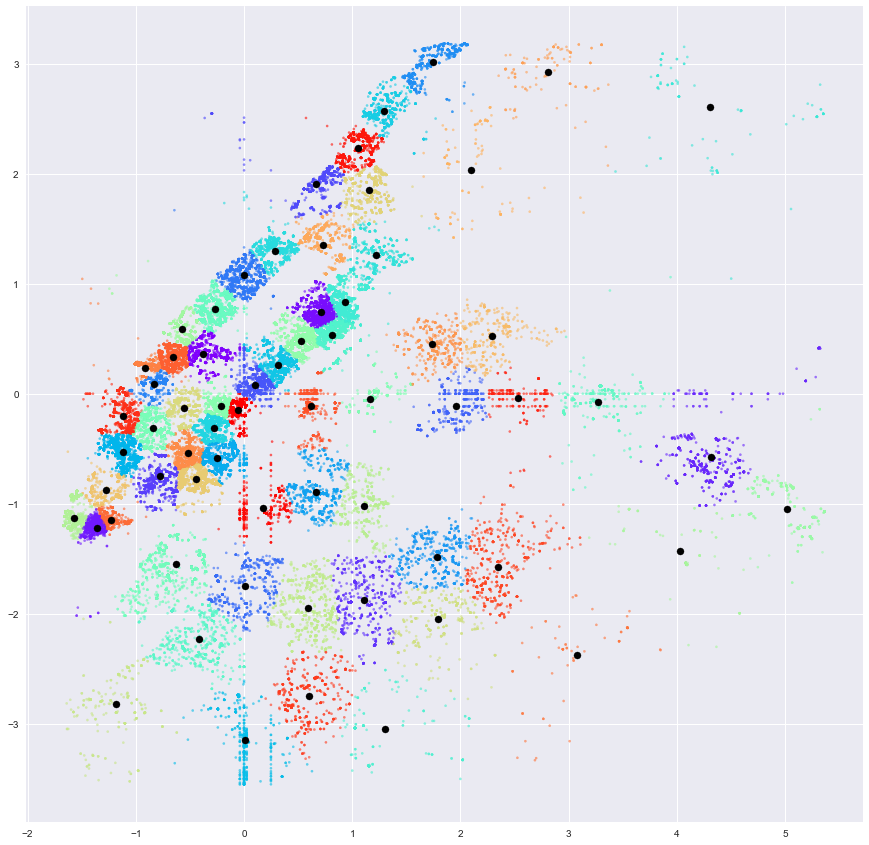

In [39]:
centers = km.cluster_centers_

plt.figure(figsize=(15,15))
plt.scatter(X_coords[:, 1], X_coords[:, 0], s=5, c=km.labels_, cmap='rainbow', alpha=0.6)
plt.scatter(centers[:,1], centers[:,0], s=50, c='black')

Compute 65 new numeric-features based on the distance from each of the 65 cluster-centers.  
These might help capture the geographical similarity between listings better than simply tracking which cluster they belong to.

In [40]:
from sklearn.metrics.pairwise import pairwise_distances
dists = pd.DataFrame(data=pairwise_distances(X_coords, km.cluster_centers_, n_jobs=-1),
                     index=cdf.index,
                     columns=['distance_to_KM_' + str(label) for label in range(km.n_clusters)])

cdf = pd.concat([cdf, dists], axis=1)

del dists

In [41]:
cdf['location_KMcluster'] = km.labels_

# One-hot encode the clusters
cdf = pd.concat([cdf, pd.get_dummies(cdf.location_KMcluster, prefix="location_KMcluster")], axis=1)

del X_coords, km

In [42]:
# Add number of buildings in cluster
cluster_size = cdf.groupby('location_KMcluster').size()
cdf['listings_in_cluster'] = cdf.location_KMcluster.map(cluster_size)

del cluster_size

cdf.shape

(124011, 252)

### Add median-price based on groups

In [43]:
# Median-price based on location_cluster
location_median_prices = cdf.groupby('location_KMcluster').price.median()
cdf['price_by_location_median'] = cdf.price / cdf.location_KMcluster.map(location_median_prices)

# Median-price based on bedrooms
bedroom_median_prices = cdf.groupby('bedrooms').price.median()
cdf['price_by_bedroom_median'] = cdf.price / cdf.bedrooms.map(bedroom_median_prices)

del location_median_prices
del bedroom_median_prices

cdf.shape

(124011, 254)

### Feature-wise Naive Bayes

There are a few categorical features (such as building_id, manager_id, location_cluster) which are very high-cardinality.  
One way to encode them efficiently is to perform a naive-bayes classifier using each feature independently, and then using the predictions from naive-bayes as new features.  

We can easily introduce some data-leakage, so we'll use K-Fold cross-validation to train and compute predictions.

In [44]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.model_selection import StratifiedKFold

def get_onehot_features(frame, variable_name, occurrence_threshold=None):
    """
    Get a matrix of onehot-encoded features for the specified (categorical) variable
    from the DataFrame 'frame'.
    """
    onehot_features = pd.get_dummies(frame[variable_name])
    if occurrence_threshold is not None:
        occurrence_counts = frame[variable_name].value_counts()
        infrequent_values = occurrence_counts[occurrence_counts < occurrence_threshold].index.tolist()
        onehot_features[variable_name+'_UNKNOWN'] = onehot_features.loc[:, infrequent_values].sum(axis=1)
        onehot_features.drop(infrequent_values, axis=1, inplace=True)
    return onehot_features

Multinomial Naive Bayes for categorical features:

Use an "occurrence threshold" to reduce the cardinality of the categorical feature, and to ensure each category has sufficient representation in the training-set.  
To do this, we'll collect all categories of the feature which occur less frequently than the threshold, and merge them into a separate category.

In [46]:
def add_mnb_predictions(train_df, test_df, variable, occurrence_threshold=None, alpha=1, folds=5):
    # Get one-hot encoding for variable, merging values which occur less frequently than the threshold
    onehot_train = get_onehot_features(train_df, variable, occurrence_threshold)
    
    # Add naive-bayes predictions to train_df using "Kfold-cross-val-like" splits
    for col in [('MNB_' + variable + '_' + c) for c in 'low medium high'.split()]:
        train_df[col] = np.nan
        test_df[col] = np.nan
    
    mnb = MultinomialNB(alpha=alpha)
    for fit_idx, pred_idx in StratifiedKFold(folds).split(onehot_train, train_df['interest_level']):
        mnb.fit(onehot_train.iloc[fit_idx, :], train_df['interest_level'].iloc[fit_idx])
        predictions = pd.DataFrame(data=mnb.predict_proba(onehot_train.iloc[pred_idx, :]),
                                   index=train_df.iloc[pred_idx].index, 
                                   columns=['MNB_' + variable + '_' + c for c in mnb.classes_])
        train_df.update(predictions)
    
    # Now add predictions to test_df
    mnb.fit(onehot_train, train_df['interest_level'])
    # Get one-hot encoding for the test_df, keeping exactly the columns from onehot_train
    unknown_value_col = variable + '_UNKNOWN' # Indicator column for unknown/merged values of 'variable'
    onehot_columns = set(onehot_train.columns)
    onehot_columns.discard(unknown_value_col)
    onehot_test = pd.get_dummies(test_df[variable]
                                 .map(lambda x: x if x in onehot_columns else unknown_value_col))
    missing_columns = pd.DataFrame(columns=(set(onehot_train.columns) - set(onehot_test.columns)),
                                   index=onehot_test.index)
    onehot_test = ( onehot_test
                       .join(missing_columns)
                       .fillna(0)
                       .reindex_axis(labels=onehot_train.columns, axis=1) )
    
    predictions = pd.DataFrame(data=mnb.predict_proba(onehot_test),
                               index=onehot_test.index,
                               columns=['MNB_' + variable + '_' + c for c in mnb.classes_])
    test_df.update(predictions)

Bernoulli Naive Bayes for binary features:

In [47]:
def add_bnb_predictions(train_df, test_df, variable, binary_column_names, alpha=1, folds=5):
    binary_train = train_df.loc[:, binary_column_names]
    
    # Add naive-bayes predictions to train_df using "Kfold-cross-val-like" splits
    for col in [('BNB_' + variable + '_' + c) for c in 'low medium high'.split()]:
        train_df[col] = np.nan
        test_df[col] = np.nan
    
    bnb = BernoulliNB(alpha=alpha)
    for fit_idx, pred_idx in StratifiedKFold(folds).split(binary_train, train_df['interest_level']):
        bnb.fit(binary_train.iloc[fit_idx, :], train_df['interest_level'].iloc[fit_idx])
        predictions = pd.DataFrame(data=bnb.predict_proba(binary_train.iloc[pred_idx, :]),
                                   index=train_df.iloc[pred_idx].index, 
                                   columns=['BNB_' + variable + '_' + c for c in bnb.classes_])
        train_df.update(predictions)
    
    # Now add predictions to test_df
    bnb.fit(binary_train, train_df['interest_level'])
    binary_test = test_df.loc[:, binary_column_names]
    
    predictions = pd.DataFrame(data=bnb.predict_proba(binary_test),
                               index=binary_test.index,
                               columns=['BNB_' + variable + '_' + c for c in bnb.classes_])
    test_df.update(predictions)

#### Grid-search for naive-bayes parameters

We'll tune for 2 parameters relevant to computing new features as naive-bayes predictions:

- The "occurrence threshold" to decide which categories of the variable to combine into one.
- "alpha": The Laplace/Lidstone smoothing parameter for the naive-bayes classifier.

In [50]:
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV

variable = 'manager_id'

for occurrence_threshold in [2,4,6,8,10,12,14]:
    var_onehot = get_onehot_features(df, variable, occurrence_threshold)

    params = {'alpha': [0.01, 0.1, 0.5, 1, 1.5, 2, 4]}
    mnb = MultinomialNB()
    gcv = GridSearchCV(estimator=mnb, param_grid=params, scoring='neg_log_loss', cv=3, verbose=0)
    gcv.fit(var_onehot, df.interest_level)
    
    print( 'Threshold = {}, Best alpha = {}, log_loss = {}'
              .format(occurrence_threshold, gcv.best_estimator_.alpha, -gcv.best_score_) )

Threshold = 2, Best alpha = 0.5, log_loss = 0.6865904753989427
Threshold = 4, Best alpha = 0.5, log_loss = 0.6844114247604918
Threshold = 6, Best alpha = 0.5, log_loss = 0.6846542473586745
Threshold = 8, Best alpha = 0.5, log_loss = 0.6870177363353648
Threshold = 10, Best alpha = 0.5, log_loss = 0.6898032233960779
Threshold = 12, Best alpha = 0.5, log_loss = 0.6915356815872513
Threshold = 14, Best alpha = 0.5, log_loss = 0.6940480639634187


For manager_id, the best combination of parameters seems to be (alpha=0.5, occurrence_threshold=4)

Use the cell above to tune for alpha and occurrence_threshold for other categorical variables:
- building_id
- street_address
- location_cluster
- bedsxbaths_str

In [51]:
columns = [col for col in df.columns if col.startswith('feature_')]

bnb = BernoulliNB()
params = {'alpha': np.arange(1,5,0.1)}
gcv = GridSearchCV(estimator=bnb, param_grid=params, scoring='neg_log_loss', cv=6, verbose=1)
gcv.fit(df.loc[:, columns], df.interest_level)
print("Best alpha = {}, best log_loss = {}".format(gcv.best_estimator_.alpha, -gcv.best_score_))

Fitting 6 folds for each of 40 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  2.2min finished


Best alpha = 1.1, best log_loss = 0.8220069979992584


#### Add naive-bayes predictions as new features

In [52]:
df = cdf.loc[cdf.test == False].drop(['test'], axis=1).copy()
tdf = cdf.loc[cdf.test == True].drop(['test'], axis=1).copy()

In [53]:
add_mnb_predictions(df, tdf, 'manager_id', occurrence_threshold=4, alpha=0.5, folds=10)
add_mnb_predictions(df, tdf, 'building_id', occurrence_threshold=2, alpha=1, folds=10)
add_mnb_predictions(df, tdf, 'street_address', occurrence_threshold=6, alpha=1.5, folds=10)
# add_mnb_predictions(df, tdf, 'display_address', occurrence_threshold=10, alpha=1.5, folds=10)
add_mnb_predictions(df, tdf, 'location_KMcluster', alpha=4.4, folds=10)
add_mnb_predictions(df, tdf, 'bedsxbaths_str', alpha=0.1, folds=10)

In [54]:
column_names = [col for col in cdf.columns if col.startswith('feature_')]
add_bnb_predictions(df, tdf, 'feature', column_names, alpha=1.5, folds=10)

### Train the model

With the features cleaned, and new engineered features added to the dataset, train the classifier model:

### Create train and test arrays

In [55]:
features_to_drop = [ 'building_id',
                     'created',
                     'description',
                     'display_address',
                     'features',
                     'manager_id',
                     'photos',
                     'street_address',
                     'location_KMcluster',
                     'bedsxbaths_str' ]
df.drop(features_to_drop, axis=1, inplace=True)
tdf.drop(features_to_drop, axis=1, inplace=True)

In [56]:
features_to_drop = ['interest_level']

features_to_drop += [c for c in df.columns if c.startswith('MNB_location_KMcluster_')]
features_to_drop += [c for c in df.columns if c.startswith('BNB_feature_')]
features_to_drop += [c for c in df.columns if c.startswith('MNB_bedsxbaths_str_')]

features_to_drop += [c for c in df.columns if re.match(r'location_KMcluster_\d+$', c)]
features_to_drop += [c for c in df.columns if re.match(r'distance_to_KM_\d+$', c)]

# features_to_drop += [c for c in df.columns if c.startswith('feature_')]

features_to_drop += [c for c in df.columns if 'round' in c]

In [57]:
X = df.drop(features_to_drop, axis=1).copy()
y = df.interest_level.copy()

from sklearn.model_selection import train_test_split, cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=34983498)

y_train_onehot = pd.get_dummies(y_train)
y_test_onehot = pd.get_dummies(y_test)
y_test_onehot.head()

,high,low,medium
17883,0,1,0
17854,1,0,0
14343,0,1,0
22447,0,1,0
14190,0,1,0


In [58]:
cdf.shape, df.shape, tdf.shape

((124011, 254), (49352, 261), (74659, 261))

In [59]:
X_train.shape, X_test.shape

((37014, 117), (12338, 117))

In [60]:
y_train.shape, y_test.shape, y_test_onehot.shape

((37014,), (12338,), (12338, 3))

### Tune XGBoost for the optimal number of estimators

In [61]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train.values, y_train.factorize()[0], feature_names=X_train.columns)
# dtrain = xgb.DMatrix(X.values, y.factorize()[0], feature_names=X.columns)

In [62]:
fixed_params = { 'colsample_bylevel': 0.8,
                 'colsample_bytree': 0.8,
                 'learning_rate': 0.175,
                 'max_depth': 4,
                 'min_child_weight': 1,
                 'objective': 'multi:softprob',
                 'scale_pos_weight': 1,
                 'subsample': 0.8,
                 'num_class': 3 }

xgbcv = xgb.cv(params=fixed_params,
               dtrain=dtrain, 
               num_boost_round=1200, 
               nfold=5, 
               stratified=True, 
               metrics=['merror','mlogloss'], 
               early_stopping_rounds=75,
               verbose_eval=50)

print('Test accuracy = ', 1-xgbcv.iloc[-1, 0])
xgbcv.tail(5)

[0]	train-merror:0.275315+0.00216532	train-mlogloss:0.988621+0.000458109	test-merror:0.278652+0.00558823	test-mlogloss:0.989494+0.00054483
[50]	train-merror:0.23096+0.00105261	train-mlogloss:0.523372+0.00147406	test-merror:0.248879+0.00402014	test-mlogloss:0.555401+0.00488321
[100]	train-merror:0.208813+0.00140455	train-mlogloss:0.482778+0.00150743	test-merror:0.243071+0.00414852	test-mlogloss:0.540596+0.00487458
[150]	train-merror:0.191252+0.00103583	train-mlogloss:0.452856+0.00155152	test-merror:0.239639+0.0025125	test-mlogloss:0.534369+0.00558749
[200]	train-merror:0.175873+0.00148441	train-mlogloss:0.427219+0.00147074	test-merror:0.23791+0.00199479	test-mlogloss:0.531624+0.00582353
[250]	train-merror:0.162168+0.00128122	train-mlogloss:0.404156+0.00145356	test-merror:0.237559+0.00365113	test-mlogloss:0.530179+0.00639547
[300]	train-merror:0.148376+0.00209781	train-mlogloss:0.382859+0.0017816	test-merror:0.23737+0.00337049	test-mlogloss:0.529186+0.00681634
[350]	train-merror:0.136401

,test-merror-mean,test-merror-std,test-mlogloss-mean,test-mlogloss-std,train-merror-mean,train-merror-std,train-mlogloss-mean,train-mlogloss-std
333,0.236424,0.003688,0.528764,0.006835,0.140373,0.001124,0.369971,0.001166
334,0.236775,0.003793,0.528796,0.006885,0.140089,0.001208,0.369605,0.001156
335,0.236776,0.003887,0.528733,0.006885,0.139832,0.001043,0.369233,0.001148
336,0.236911,0.003600,0.528702,0.006880,0.139663,0.001120,0.368887,0.001171
337,0.237073,0.003977,0.528699,0.006861,0.139420,0.001154,0.368571,0.001183


### Train the XGBClassifier

In [63]:
from xgboost import XGBClassifier

fixed_params = {
    'colsample_bylevel': 0.8,
    'colsample_bytree': 0.8,
    'learning_rate': 0.175,
    'max_depth': 4,
    'n_estimators': 340,
    'min_child_weight': 1,
    'objective': 'multi:softprob',
    'scale_pos_weight': 1,
    'subsample': 0.8
}

model = XGBClassifier(**fixed_params)
model.fit(X_train, y_train, verbose=True)

XGBClassifier(base_score=0.5, colsample_bylevel=0.8, colsample_bytree=0.8,
       gamma=0, learning_rate=0.175, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=340, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8)

### Evaluate accuracy on the test-set

In [64]:
from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(X_test)
y_prob = pd.DataFrame(data=model.predict_proba(X_test), columns=model.classes_)

classes = ['high', 'medium', 'low']
y_prob = y_prob.reindex_axis(labels=classes, axis=1)
y_test_onehot = y_test_onehot.reindex_axis(labels=classes, axis=1)

print("(Train) Accuracy = ", model.score(X_train, y_train))
print("(Test) Accuracy = ", accuracy_score(y_test, y_pred))
print("(Test) Log-loss = ", log_loss(y_test_onehot, y_prob))

print("\n")
print("Classification report\n")
print(classification_report(y_test, y_pred, labels=classes))

pd.DataFrame( confusion_matrix(y_test, y_pred, labels=classes), 
              index= ['true_'+classes[i] for i in range(len(classes))],
              columns= ['pred_'+classes[i] for i in range(len(classes))] )

(Train) Accuracy =  0.846976819582
(Test) Accuracy =  0.767223212838
(Test) Log-loss =  0.521350910751


Classification report

             precision    recall  f1-score   support

       high       0.63      0.32      0.43       977
     medium       0.53      0.46      0.49      2770
        low       0.84      0.92      0.87      8591

avg / total       0.75      0.77      0.75     12338



,pred_high,pred_medium,pred_low
true_high,315,477,185
true_medium,140,1266,1364
true_low,44,662,7885


### Plot feature-importances

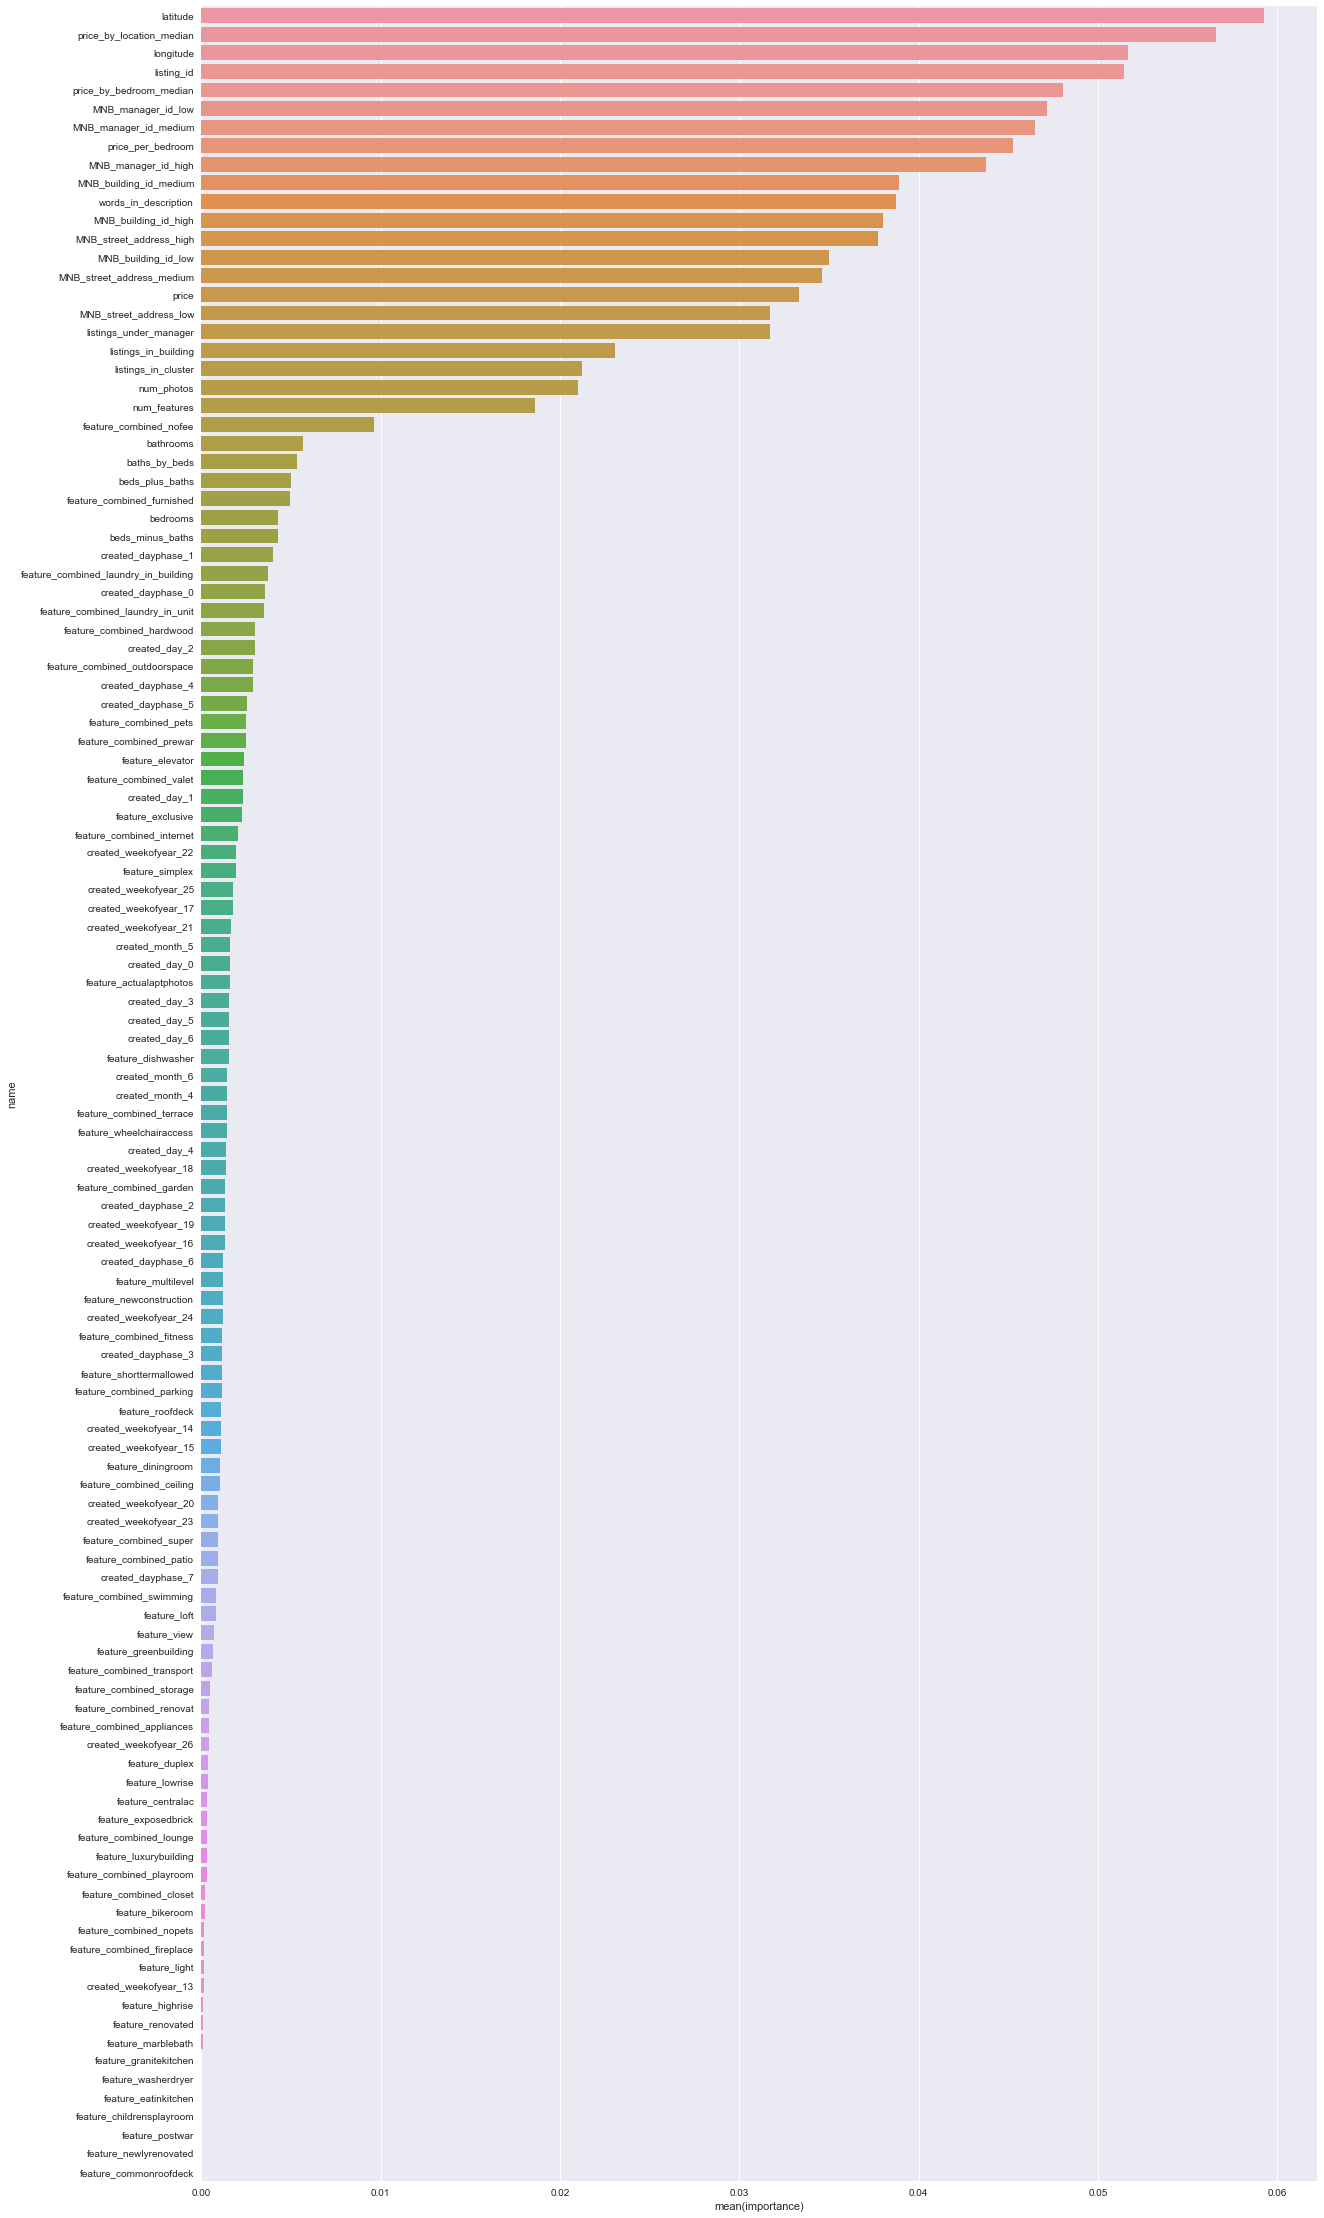

In [65]:
feature_imp = pd.DataFrame({'name': X_train.columns,
                            'importance':model.feature_importances_})
feature_imp.sort_values('importance', ascending=False, inplace=True)

set_figure_size(20,40)
sns.barplot(x='importance', y='name', data=feature_imp)

### Predict on holdout/submission set

#### First train on the entire labeled set using the tuned parameters

In [66]:
# Train on entire df
fixed_params = {
    'colsample_bylevel': 0.8,
    'colsample_bytree': 0.8,
    'learning_rate': 0.175,
    'max_depth': 4,
    'n_estimators': 500,
    'min_child_weight': 1,
    'objective': 'multi:softprob',
    'scale_pos_weight': 1,
    'subsample': 0.8
}

model = XGBClassifier(**fixed_params)
model.fit(X, y, verbose=True)

XGBClassifier(base_score=0.5, colsample_bylevel=0.8, colsample_bytree=0.8,
       gamma=0, learning_rate=0.175, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=500, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8)

In [67]:
train_features = X.columns

X_submit = tdf[train_features].copy()
submit_listing_ids = tdf['listing_id'].values

X_submit.shape

(74659, 117)

In [68]:
submit_prob = pd.DataFrame(data=model.predict_proba(X_submit),
                           columns=model.classes_)

submit_prob['listing_id'] = submit_listing_ids
submit_prob = submit_prob.reindex_axis(labels=['listing_id', 'high', 'medium', 'low'], axis=1)

submit_prob.head()

,listing_id,high,medium,low
0,7142618,0.129146,0.622372,0.248482
1,7210040,0.006755,0.028815,0.964430
2,7103890,0.096970,0.231050,0.671981
3,7143442,0.081129,0.517308,0.401564
4,6860601,0.016544,0.238050,0.745405


In [69]:
submit_prob.to_csv("testset_predictions.csv", index=False)

submit_prob.describe()

,listing_id,high,medium,low
count,7.465900e+04,7.465900e+04,74659.000000,74659.000000
mean,7.024001e+06,7.443190e-02,0.228154,0.697414
std,1.264496e+05,1.461842e-01,0.208394,0.298449
min,6.811958e+06,2.177313e-07,0.000010,0.000144
25%,6.915516e+06,8.923518e-04,0.028906,0.469243
50%,7.021738e+06,1.075638e-02,0.175805,0.801132
75%,7.129166e+06,7.083783e-02,0.397766,0.968792
max,7.761779e+06,9.909630e-01,0.924345,0.999988


### Grid-search to determine the optimal subset of features

In [288]:
feature_lists = []
flist0 = [c for c in df.columns 
              if c != 'interest_level' 
              and re.match(r'[MB]NB_', c) is None 
              and re.match(r'location_KMcluster_\d+', c) is None
              and re.match(r'distance_to_KM_\d+', c) is None
              and 'itude_round' not in c]
# 0 - feature_binary
feature_lists.append(flist0)

#1 - NB:[manager, building, street]; feature_binary
feature_lists.append(feature_lists[0] + [c for c in df.columns 
                                             if 'MNB_manager_id' in c 
                                             or 'MNB_building_id' in c 
                                             or 'MNB_street_address' in c])

#2 - NB:[manager, building, street, location]; feature_binary
feature_lists.append(feature_lists[1] + [c for c in df.columns if 'MNB_location_' in c])

#3 - NB:[manager, building, street]; location_onehot, feature_binary
feature_lists.append(feature_lists[1] + [c for c in df.columns if re.match(r'location_KMcluster_\d+', c)])

#4 - NB:[manager, building, street]; distance_to_KM, feature_binary
feature_lists.append(feature_lists[1] + [c for c in df.columns if 'distance_to_KM' in c])

#5 - NB:[manager, building, street]; *itude_round, feature_binary
feature_lists.append(feature_lists[1] + [c for c in df.columns if 'itude_round' in c])

#6 - NB:[manager, building, street, bedsxbaths]; feature_binary
feature_lists.append(feature_lists[1] + [c for c in df.columns if 'MNB_bedsxbaths_str' in c])

#7 - NB:[manager, building, street, bedsxbaths]; *itude_round, feature_binary
feature_lists.append(feature_lists[6] + [c for c in df.columns if 'itude_round' in c])

#8 - NB:[manager, building, street, bedsxbaths]; distance_to_KM, feature_binary
feature_lists.append(feature_lists[6] + [c for c in df.columns if 'distance_to_KM' in c])

#9 - NB:[manager, building, street, bedsxbaths]; location_onehot, feature_binary
feature_lists.append(feature_lists[3] + [c for c in df.columns if 'MNB_bedsxbaths_str' in c])

In [289]:
params = { 
    'colsample_bylevel': 0.8,
    'colsample_bytree': 0.8,
    'learning_rate': 0.15,
    'max_depth': 4,
    'min_child_weight': 1,
    'objective': 'multi:softprob',
    'scale_pos_weight': 1,
    'subsample': 0.8,
    'num_class': 3 
}

feature_list_scores = pd.DataFrame(columns='n_estimators test_loss test_acc train_loss train_acc'.split())

In [321]:
for i, features in enumerate(feature_lists[9:], 9):
    dtrain = xgb.DMatrix(data=df.loc[:, features].values.copy(), 
                         label=df.interest_level.factorize()[0], 
                         feature_names=df.loc[:, features].columns)
    
    print('------------------------------------------------------------------------')
    print('Feature-list [{}]:'.format(i,))
    xgbcv = xgb.cv(params=params,
                   dtrain=dtrain, 
                   num_boost_round=1200, 
                   nfold=6, 
                   stratified=True, 
                   metrics=['merror','mlogloss'], 
                   early_stopping_rounds=75,
                   verbose_eval=100)
    
    d = dict(n_estimators = xgbcv.shape[0],
             test_loss = xgbcv.iloc[-1]['test-mlogloss-mean'], 
             train_loss = xgbcv.iloc[-1]['train-mlogloss-mean'],
             test_acc = 1 - xgbcv.iloc[-1]['test-merror-mean'], 
             train_acc = 1 - xgbcv.iloc[-1]['train-merror-mean'])
    feature_list_scores.loc[i] = d
    for k,v in d.items():
        print(k, '=>', v)

------------------------------------------------------------------------
Feature-list [9]:
[0]	train-merror:0.275462+0.00125409	train-mlogloss:1.00403+0.00051043	test-merror:0.280272+0.00307921	test-mlogloss:1.00482+0.000854811
[100]	train-merror:0.219116+0.000803991	train-mlogloss:0.498842+0.0013855	test-merror:0.2423+0.00236149	test-mlogloss:0.53845+0.00565877
[200]	train-merror:0.193261+0.00144407	train-mlogloss:0.455296+0.00132503	test-merror:0.234661+0.00369239	test-mlogloss:0.525756+0.00628949
[300]	train-merror:0.172755+0.00112793	train-mlogloss:0.421498+0.00120306	test-merror:0.232716+0.00326457	test-mlogloss:0.520444+0.00660142
[400]	train-merror:0.155139+0.00115096	train-mlogloss:0.392781+0.00117418	test-merror:0.231399+0.00314591	test-mlogloss:0.517841+0.00676569
[500]	train-merror:0.138985+0.00118915	train-mlogloss:0.367131+0.00110152	test-merror:0.231277+0.00392319	test-mlogloss:0.517289+0.0070366
[600]	train-merror:0.12453+0.00129094	train-mlogloss:0.344183+0.00121102	tes

In [324]:
feature_list_scores

,n_estimators,test_loss,test_acc,train_loss,train_acc
0,505.0,0.535911,0.761793,0.406368,0.837879
1,545.0,0.519232,0.768439,0.359780,0.864512
2,578.0,0.518018,0.768581,0.348361,0.871576
3,537.0,0.517451,0.769796,0.361092,0.864711
4,627.0,0.516095,0.770850,0.335219,0.880009
5,569.0,0.517894,0.768297,0.353292,0.869189
6,521.0,0.518704,0.767588,0.361911,0.863843
7,474.0,0.517584,0.767932,0.372841,0.856362
8,601.0,0.516159,0.769351,0.338326,0.877898
9,551.0,0.517012,0.769168,0.355507,0.868131


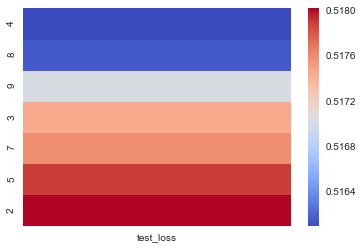

In [325]:
# set_figure_size(10,10)
sns.heatmap(feature_list_scores[['test_loss']].sort_values('test_loss').head(7), cmap='coolwarm')